Epoch 1, Loss: 0.06731074483692646
Epoch 2, Loss: 0.033947757512331006
Epoch 3, Loss: 0.032337305620312694
Epoch 4, Loss: 0.03185565207898617
Epoch 5, Loss: 0.031652857072651384
Epoch 6, Loss: 0.031529157504439353
Epoch 7, Loss: 0.031467549726367
Epoch 8, Loss: 0.031431221090257165
Epoch 9, Loss: 0.03139903377741575
Epoch 10, Loss: 0.03138154441863299
Epoch 11, Loss: 0.03136872369796038
Epoch 12, Loss: 0.03135532493889332
Epoch 13, Loss: 0.03135060745477676
Epoch 14, Loss: 0.03133982330560684
Epoch 15, Loss: 0.03133226819336414
Epoch 16, Loss: 0.031327153004705906
Epoch 17, Loss: 0.03132439410686493
Epoch 18, Loss: 0.0313202069401741
Epoch 19, Loss: 0.03131721556186676
Epoch 20, Loss: 0.031313113436102866
Epoch 21, Loss: 0.031312425442039965
Epoch 22, Loss: 0.03131149178743362
Epoch 23, Loss: 0.031311485663056374
Epoch 24, Loss: 0.031307952582836154
Epoch 25, Loss: 0.03130872076004743
Epoch 26, Loss: 0.03130741023272276
Epoch 27, Loss: 0.031308606281876566
Epoch 28, Loss: 0.03130802532

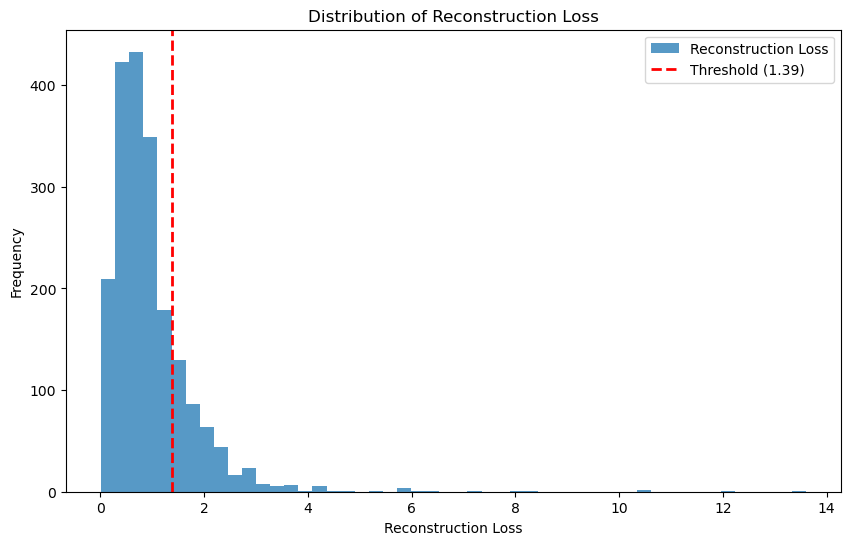

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [5]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# 1. Đọc dữ liệu
data = pd.read_csv('../../data/ai4i2020.csv')

# 2. Xóa cột không cần thiết (nếu có) và chuẩn hóa dữ liệu
X = data.drop(columns=['UDI','Product ID','Type','Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])  # Loại bỏ các nhãn lỗi

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Chuẩn hóa dữ liệu

# 3. Chia tập dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Chuyển sang tensor cho PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 4. Xây dựng mô hình VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc21 = nn.Linear(16, latent_dim)  # Mean vector
        self.fc22 = nn.Linear(16, latent_dim)  # Log variance vector

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 16)
        self.fc4 = nn.Linear(16, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Khởi tạo mô hình VAE
input_dim = X_train.shape[1]
latent_dim = 2
model = VAE(input_dim, latent_dim)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 5. Huấn luyện mô hình
epochs = 50
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        recon_loss = criterion(x_hat, x)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')

# 6. Đánh giá mô hình và vẽ đồ thị
model.eval()
with torch.no_grad():
    X_test_pred, _, _ = model(X_test_tensor)
    reconstruction_loss = torch.mean((X_test_tensor - X_test_pred) ** 2, dim=1).numpy()

# Thiết lập ngưỡng phát hiện bất thường
threshold = np.percentile(reconstruction_loss, 80)  # Ngưỡng 80%
print(f"Threshold (Ngưỡng): {threshold}")

# Dự đoán nhãn dựa trên ngưỡng
y_pred = (reconstruction_loss > threshold).astype(int)

# Vẽ đồ thị của reconstruction_loss
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=50, alpha=0.75, label='Reconstruction Loss')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold ({threshold:.2f})')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Loss')
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Lấy nhãn thực tế từ tập kiểm tra
y_test = data.loc[X_test.index, 'Machine failure']

# In Confusion Matrix và Classification Report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Tính và in ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# Vẽ biểu đồ của reconstruction_loss và ngưỡng
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=50, alpha=0.75, label='Reconstruction Loss')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold ({threshold:.2f})')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Loss')
plt.legend()
plt.show()
